In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import norm
import json
import os
import random

In [2]:
np.random.seed(21)
random.seed(21)

### 리뷰 데이터 (스포일러 여부 항목: is_spoiler)

In [3]:
df_reviews = pd.read_json('/content/drive/MyDrive/project4/IMDB_reviews.json', lines=True).drop_duplicates("review_text").sample(frac=1)
print(df_reviews.shape)
df_reviews.tail()

(573385, 7)


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
482453,5 March 2002,tt0100935,ur1635605,False,It was a Sunday night and since I have been on...,9,Just one question. Why?
566918,15 June 2003,tt0143145,ur1100711,False,I don't consider myself a die hard James Bond ...,7,This Bond film was Enough for me and I mean th...
64053,21 February 2013,tt0095016,ur33374263,False,"What has now become a Classic formula of the ""...",8,Blockbuster
82176,11 October 2014,tt2267998,ur55757311,False,This is a thrillingly boring movie. It is clic...,1,Gone is the word
202841,16 May 2015,tt0470752,ur11786257,True,Obviously this film has a ZEITGEIST aspect and...,7,Not a bad effort


1. 영화 리뷰 데이터 정보 

review_date: 리뷰가 쓰여진 날짜. 

movie_id: 영화 고유 아이디. 

user_id: 리뷰 작성자 고유 아이디. 

is_spoiler: 스포일러 있음. 

review_text: 리뷰 텍스트. 

rating: Rating: 작성자가 매긴 평점. 

review_summary: 리뷰 요약. 

### 영화 정보 데이터

In [4]:
df_details = pd.read_json('/content/drive/MyDrive/project4/IMDB_movie_details.json', lines=True)
print(df_details.shape)
df_details.tail()

(1572, 7)


,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
1567,tt0289879,Evan Treborn grows up in a small town with his...,1h 53min,"[Sci-Fi, Thriller]",7.7,2004-01-23,"In the year 1998, Evan Treborn (Ashton Kutcher..."
1568,tt1723811,Brandon is a 30-something man living in New Yo...,1h 41min,[Drama],7.2,2012-01-13,"Brandon (Michael Fassbender) is a successful, ..."
1569,tt5013056,Evacuation of Allied soldiers from the British...,1h 46min,"[Action, Drama, History]",8.1,2017-07-21,The film alternates between three different pe...
1570,tt0104014/,"For a while now, beautiful 24-year-old Diana B...",1h 33min,"[Comedy, Drama]",5.3,1992-02-21,
1571,tt0114142/,"The marriage of David Burgess, a senior execut...",1h 32min,"[Drama, Thriller]",4.0,1999-01-29,


2. 영화 정보 데이터 칼럼 정보 

movie_id: 영화 고유 아이다. 

plot_summary: 스포일러가 있지 않은 영화 정보. 

duration: 영화 재생 시간. 

genre: 장르. 

rating: 평점. 

release_date: 영화 개봉 날짜. 

plot_synopsis: 스포일러를 포함한 영화 줄거리. 

## 데이터 전처리

### 타입과 결측치 확인

In [5]:
# 타입과 결측치 확인

print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573385 entries, 5866 to 202841
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573385 non-null  object
 1   movie_id        573385 non-null  object
 2   user_id         573385 non-null  object
 3   is_spoiler      573385 non-null  bool  
 4   review_text     573385 non-null  object
 5   rating          573385 non-null  int64 
 6   review_summary  573385 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 31.2+ MB
None


In [6]:
print(df_details.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1572 non-null   object 
dtypes: float64(1), object(6)
memory usage: 86.1+ KB
None


In [7]:
print('사용자 리뷰 : ', df_reviews.shape)
print('영화 정보 : ', df_details.shape)

사용자 리뷰 :  (573385, 7)
영화 정보 :  (1572, 7)


In [8]:
# 전체 데이터셋의 스포일러 갯수 
num_spoilers = sum(df_reviews.is_spoiler)

num_notice = df_reviews.review_text.str.contains('spoiler', case=False).sum() / \
             df_reviews.is_spoiler.sum()

print('전체 스포일러 갯수: %.4f' % num_spoilers)             
print('자신의 리뷰를 스포일러로 선언하는지 대략적인 비율: %.4f' % num_notice)

전체 스포일러 갯수: 150856.0000
자신의 리뷰를 스포일러로 선언하는지 대략적인 비율: 0.1752


In [9]:
# 데이터 중복확인 

print(df_details[['plot_summary']].duplicated().any())
print(df_details[['plot_synopsis']].duplicated().any())
print(df_details[['movie_id']].duplicated().any())

False
True
False


### 제거할 칼럼 선택

In [10]:
#영화 요약본과 시놉시스 요약본 길이 비교 

df_details['summary_len'] = df_details['plot_summary'].apply(lambda x: len(x))
df_details['synopsis_len'] = df_details['plot_synopsis'].apply(lambda x: len(x))

In [11]:
df_details[['summary_len', 'synopsis_len']].describe() # 시놉시스 길이가 훨씬 긴 것으로 보인다. 

,summary_len,synopsis_len
count,1572.000000,1572.000000
mean,614.258270,8214.993639
std,240.194629,8435.385266
min,95.000000,0.000000
25%,423.750000,2898.750000
50%,578.000000,6192.500000
75%,783.500000,10871.000000
max,1077.000000,63904.000000


스포일러는 영화의 줄거리애서 알 수 있는 경우가 많다. 리뷰 데이터 세트에는 리뷰 텍스트(review_text) 칼럼이 있고, 세부 데이터 세트에는 플롯 시놉시스(plot_synopsis)와 플롯 요약(plot_summary)이 있다. 

여기서 스포일러 리뷰가 플롯 요약과 유사하다는 가정하에, 리뷰 요약은 불필요할 것 같아 삭제했다. 

* GloVe 미국 스탠포드대학에서 2014년 개발한 워드 임베딩 방법론이다. 워드투백의 단점을 보완했다고 한다. 워드투벡은 중심단어로 주변단어를, 주변단어로 중심단어를 예측하는 워드투벡의 단점을 예측하는 방법이다. 주변 단어를 어떻게 지정하느냐에 따라 주변 정보 반영이 어려운 단점이 있는데, GloVe는 임베딩된 두 단어벡터의 내적이 말뭉치 전체에서 동시 등장확률 로그값이 되도록 목적함수를 정의했다. 

In [12]:
df_reviews.head(3)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
5866,18 April 2014,tt0068646,ur43729203,False,"""The Godfather"" is much more than a story abou...",10,The Godfather... the masterpiece...
132924,13 February 2010,tt0814255,ur20486886,False,The original book was written to an audience o...,3,Successfully butchered another good book.
37540,13 February 2016,tt0482571,ur64523291,True,This movie had the potential to be excellent. ...,5,Could've Been Great


In [13]:
df_reviews[df_reviews[['review_summary']].duplicated()].head(3)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
228377,9 March 2015,tt2322441,ur59140441,False,I have read all 3 books and couldn't put them ...,10,Loved it
218405,31 December 2014,tt2305051,ur0391152,False,A wonder. Reese Witherspoon stars as Cheryl St...,9,Excellent
294788,15 October 2002,tt0203009,ur1953250,False,Moulin Rouge has to be the most boring movie I...,1,Boring


In [14]:
#리뷰 서머리 삭제 

df_reviews = df_reviews.drop(['review_summary'], axis=1)
df_reviews.head(3)

,review_date,movie_id,user_id,is_spoiler,review_text,rating
5866,18 April 2014,tt0068646,ur43729203,False,"""The Godfather"" is much more than a story abou...",10
132924,13 February 2010,tt0814255,ur20486886,False,The original book was written to an audience o...,3
37540,13 February 2016,tt0482571,ur64523291,True,This movie had the potential to be excellent. ...,5


In [15]:
# 장르

genre_names = np.unique(np.array(' '.join(df_details.genre.str.join(' ')).split()))
print(genre_names)

['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime' 'Drama'
 'Family' 'Fantasy' 'Film-Noir' 'History' 'Horror' 'Music' 'Musical'
 'Mystery' 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'War' 'Western']


Text(0, 0.5, 'Number of genre')

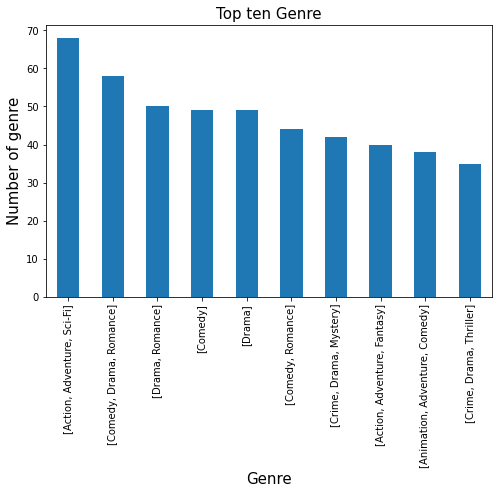

In [16]:
top_genre=df_details['genre'].value_counts(sort=True)  #sort=true로 하면 내림차순 정렬
top_genre[:10].plot(kind='bar',figsize=(8,5)) #[:10] -> 10개 까지만
plt.title('Top ten Genre',fontsize=15)
plt.xlabel('Genre',fontsize=15)
plt.ylabel('Number of genre',fontsize=15)

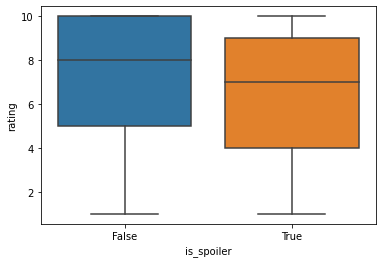

In [17]:
# 평점
sns.boxplot(x=df_reviews.is_spoiler,y=df_reviews.rating);

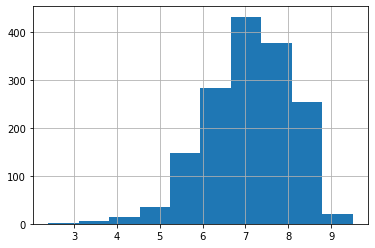

In [18]:
df_details['rating'].hist();

In [19]:

# 5점 미만의 영화는 제외
under5 = df_details[(df_details['rating'] < 5)].index
df_details = df_details.drop(under5)

In [20]:
# duration
df_details['duration'][:10]

0    1h 57min
1    1h 45min
2    1h 37min
3     2h 6min
4    1h 43min
5    2h 18min
6    2h 17min
7    1h 37min
8    2h 22min
9    1h 24min
Name: duration, dtype: object

In [21]:
# duration -> min

def duration_to_int(value):
    if 'h' in value:
        hour = int(value.split('h')[0])
        if len(value.split('h')[1]) > 0:
            minute = int(value.split('h ')[1].split('min')[0])
        else:
            minute = 0
    else:
        hour = 0
        minute = int(value.split('min')[0])
    
    return hour * 60 + minute

In [22]:
df_details['duration'] = df_details['duration'].apply(duration_to_int)

In [23]:
df_details['duration'] = df_details['duration'].astype(int)

<Figure size 1440x720 with 0 Axes>

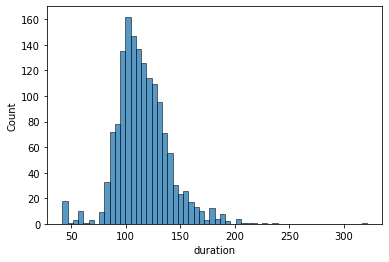

<Figure size 1440x720 with 0 Axes>

In [24]:
plt.subplot
sns.histplot(data=df_details, x='duration')
plt.figure(figsize=(20, 10))

In [25]:
# 80분 이하, 210분 이상의 영화 제거
gap = df_details[(df_details['duration'] <= 80) | (df_details['duration'] >= 210)].index
df_details = df_details.drop(gap)

In [26]:
print(df_details.shape)

(1487, 9)


In [27]:
# review_date, release_date: 연도만 남기기
df_details['release_year'] = df_details['release_date'].apply(lambda x: x[:4])
df_details['release_year'] = df_details['release_year'].astype('int')

In [28]:
df_reviews['review_year'] = df_reviews['review_date'].apply(lambda x: x[-4:])
df_reviews['review_year'] = df_reviews['review_year'].astype('int')

In [29]:
df_details.head(3)

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis,summary_len,synopsis_len,release_year
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",117,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",1034,8605,1992
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",105,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...,657,5371,2013
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",97,"[Comedy, Romance]",6.7,2002-04-11,,667,0,2002


In [30]:
df_reviews.head(3)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_year
5866,18 April 2014,tt0068646,ur43729203,False,"""The Godfather"" is much more than a story abou...",10,2014
132924,13 February 2010,tt0814255,ur20486886,False,The original book was written to an audience o...,3,2010
37540,13 February 2016,tt0482571,ur64523291,True,This movie had the potential to be excellent. ...,5,2016


In [31]:
df_reviews= df_reviews.drop(['review_date'], axis=1)

In [32]:
df_details = df_details.drop(['release_date'], axis=1)

In [33]:
df_details = df_details.drop(['genre', 'duration', 'plot_synopsis'], axis=1)

In [34]:
df_details.head(1)

,movie_id,plot_summary,rating,summary_len,synopsis_len,release_year
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",6.9,1034,8605,1992


In [35]:
df_reviews.head(1)

,movie_id,user_id,is_spoiler,review_text,rating,review_year
5866,tt0068646,ur43729203,False,"""The Godfather"" is much more than a story abou...",10,2014


### 문자 전처리

In [36]:
import re

In [37]:
# 모두 소문자로 정리

df_details['plot_summary'] = df_details['plot_summary'].apply(lambda x: x.lower())
df_reviews['review_text'] = df_reviews['review_text'].apply(lambda x: x.lower())


In [38]:
def text_to_word(value):
    value = re.sub(r"[^a-zA-Z0-9 ']", '', value)
    value = value.replace('i ', 'I ')
    value = value.replace("i'", "I'")
    ' '.join(value.split())
    return value

In [39]:
df_details['plot_summary'] = df_details['plot_summary'].apply(text_to_word)
df_reviews['review_text'] = df_reviews['review_text'].apply(text_to_word)

### 데이터 파일 병합

In [40]:
df = pd.merge(df_details, df_reviews, on='movie_id', how='inner')

print(df.shape)
df.head(2)

(550391, 11)


,movie_id,plot_summary,rating_x,summary_len,synopsis_len,release_year,user_id,is_spoiler,review_text,rating_y,review_year
0,tt0105112,former cia analyst jack ryan is in england wit...,6.9,1034,8605,1992,ur23055365,False,patriot games is a great movie with a very wel...,8,2014
1,tt0105112,former cia analyst jack ryan is in england wit...,6.9,1034,8605,1992,ur0020866,False,phillip noyce takes the helm for the first tim...,9,2009


In [41]:
# 1990년 이전 영화는 제외
remove90 = df[(df['release_year'] < 1990)].index
df = df.drop(remove90)

In [42]:
print(df.shape)

(513544, 11)


In [43]:
df.head(2)

,movie_id,plot_summary,rating_x,summary_len,synopsis_len,release_year,user_id,is_spoiler,review_text,rating_y,review_year
0,tt0105112,former cia analyst jack ryan is in england wit...,6.9,1034,8605,1992,ur23055365,False,patriot games is a great movie with a very wel...,8,2014
1,tt0105112,former cia analyst jack ryan is in england wit...,6.9,1034,8605,1992,ur0020866,False,phillip noyce takes the helm for the first tim...,9,2009


In [44]:
df.columns = ['movie_id', 'summary', 'score', 'summary_len', 'synopsis_len', 'release_year', 'user_id', 'is_spoiler', 'review', 'score_by_user', 'review_year']

df.head(3)

,movie_id,summary,score,summary_len,synopsis_len,release_year,user_id,is_spoiler,review,score_by_user,review_year
0,tt0105112,former cia analyst jack ryan is in england wit...,6.9,1034,8605,1992,ur23055365,False,patriot games is a great movie with a very wel...,8,2014
1,tt0105112,former cia analyst jack ryan is in england wit...,6.9,1034,8605,1992,ur0020866,False,phillip noyce takes the helm for the first tim...,9,2009
2,tt0105112,former cia analyst jack ryan is in england wit...,6.9,1034,8605,1992,ur2206551,False,a fairly straightforward action thriller that ...,7,2008
